# Naive Classifier

The purpose of this code is to provide a benchmark against which we can test the neural network

It demonstrates that actually building something simple is actually quite hard

The input data is the same as that for the neural network - but it must be exactly balanced


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode


In [3]:
#df = pd.read_csv('data/09_01_2020_use_name_no_burg.csv')
# must use a balanced data set
df = pd.read_csv('07_07_2020_final.csv')

valid_idx = df[df.valid].index
train_idx = df[~df.valid].index

bal_idx = []
for k, v in zip(df.index, df.bal):
    bal_idx += [k]*v

In [4]:
train_df = df.iloc[train_idx, [3,2,0,1]]
bal_df = df.iloc[bal_idx, [3,2,0,1]]
valid_df = df.iloc[valid_idx, [3,2]]

Here we need to switch back from fast food to the individual labels
Otherwise Fast Food ends up with all chicken, burger etc labels. We reintroduce the concept of fast food again later on if a name scores highly on multiple categories

In [5]:
bal_df['label_final'] = np.where((((bal_df['label'] == 'Burger') | (bal_df['label2'] == 'Burger')) & (bal_df['label_final'] == 'Fast Food')), 'Burger', bal_df['label_final'])
bal_df['label_final'] = np.where((((bal_df['label'] == 'Kebab') | (bal_df['label2'] == 'Kebab')) & (bal_df['label_final'] == 'Fast Food')), 'Kebab', bal_df['label_final'])
bal_df['label_final'] = np.where((((bal_df['label'] == 'Pizza') | (bal_df['label2'] == 'Pizza')) & (bal_df['label_final'] == 'Fast Food')), 'Pizza', bal_df['label_final'])
bal_df['label_final'] = np.where((((bal_df['label'] == 'Chicken') | (bal_df['label2'] == 'Chicken')) & (bal_df['label_final'] == 'Fast Food')), 'Chicken', bal_df['label_final'])

In [6]:
#For every name, split it into individual words
# For each category, count up the most frequent word in that category
# The counts become an indication of how important that word is in the category
labels = bal_df.label_final.unique()
big_list = []
for label in labels:
    counts = Counter(_ for _ in " ".join((list(bal_df.ascii_name_fix[bal_df.label_final==label]))).split()).most_common(10000)
    big_list += [[word[0],label, word[1]] for word in counts]

In [7]:
# We take out Fast Food because it is just a constructed category from the fundamental
# food types chicken, burger, pizza, kebab
df2 = pd.DataFrame.from_records(big_list, columns=['word', 'label', 'count'])
df2 = df2[df2.label != 'Fast Food']

In [8]:
#remove some common and unhelpful words
# Force the fast foods into their own categories by giving a score of 500

to_drop = ['the', 'and', 'of', 'restaurant', 'takeaway', '@', '-']
for word in to_drop:
    df2 = df2[df2['word'] != word]

to_drop = ['kebab', 'pizza', 'chicken', 'burger', 'kebabs', 'pizzas', 'burgers']
for word in to_drop:
    df2 = df2[df2['word'] != word]

    
df2.reset_index(inplace = True, drop = True)
    
df2.loc[len(df2)] = ['kebab', 'Kebab', 500]
df2.loc[len(df2)] = ['kebabs', 'Kebab', 500]
df2.loc[len(df2)] = ['pizza', 'Pizza', 500]
df2.loc[len(df2)] = ['pizzas', 'Pizza', 500]
df2.loc[len(df2)] = ['chicken', 'Chicken', 500]
df2.loc[len(df2)] = ['burger', 'Burger', 500]
df2.loc[len(df2)] = ['burgers', 'Burger', 500]

In [9]:
# This gives a 1 or 0 for whether the word is in a category
# It doesn't seem to work so well
#df3=pd.DataFrame(pd.pivot_table(df2, values='count', index='word', columns='label', aggfunc='count', fill_value=0).to_records())


# This gives a value >0 for how often the word is in a category. These can be absolute as we have
# a balanced dataset
df3=pd.DataFrame(pd.pivot_table(df2, values='count', index='word', columns='label', aggfunc='sum', fill_value=0).to_records())

In [10]:
df3[df3['word']=='roll']

,word,Burger,Chicken,Desserts,Fish & Chips,Kebab,Pizza,Sand/Caf/Bake,South Asian,Southeast & East Asian
6511,roll,7,0,11,0,3,0,26,0,9


In [11]:
df3[df3['word']=='kebab']

,word,Burger,Chicken,Desserts,Fish & Chips,Kebab,Pizza,Sand/Caf/Bake,South Asian,Southeast & East Asian
4013,kebab,0,0,0,0,500,0,0,0,0


In [12]:
my_dict = df3.set_index('word').T.to_dict('list')

In [13]:
# Now apply to validation set
# Split the name into words
# For each word take the scores for each category and add these scores for all the words in the name
# If no words in any category, guess!
# For fast food, if there are more than 1 categories that are bigger than a threshold, then fast food
# Else take the maximum category

fast_foods = ['Pizza', 'Burger', 'Kebab', 'Chicken']
my_cols = df3.columns[1:]
len_labels = len(my_cols)
final_list =[]
for name in valid_df.ascii_name_fix:
    little_list = np.zeros(len_labels)
    for item in name.split():
        if item in my_dict:
            little_list = np.array(my_dict[item]) + little_list
    if not np.any(little_list):
        final_list.append(random.choice(my_cols))
        #final_list.append('Other')
    else:
        #final_list.append(little_list)
        max_cat = little_list.max()
        temp_list = [1 if x > 0.5 else 0 for x in little_list/max_cat]
        ff_check = list(my_cols[[x==1 for x in temp_list]])
        if sum(el in ff_check for el in fast_foods) > 1:
            final_list.append('Fast Food')
        else:
            final_list.append(my_cols[little_list.argmax()])
        

In [14]:
final_list

['South Asian',
 'Fast Food',
 'Pizza',
 'Fast Food',
 'Southeast & East Asian',
 'Sand/Caf/Bake',
 'Burger',
 'Kebab',
 'Kebab',
 'Kebab',
 'Southeast & East Asian',
 'Fast Food',
 'Sand/Caf/Bake',
 'Fish & Chips',
 'Kebab',
 'Sand/Caf/Bake',
 'Sand/Caf/Bake',
 'Pizza',
 'Southeast & East Asian',
 'Fish & Chips',
 'Fast Food',
 'Fast Food',
 'Sand/Caf/Bake',
 'Kebab',
 'Fast Food',
 'Fast Food',
 'South Asian',
 'Chicken',
 'Fish & Chips',
 'Fast Food',
 'Fish & Chips',
 'Southeast & East Asian',
 'Sand/Caf/Bake',
 'Desserts',
 'Southeast & East Asian',
 'Fast Food',
 'Pizza',
 'Fish & Chips',
 'Fish & Chips',
 'Sand/Caf/Bake',
 'South Asian',
 'Kebab',
 'Southeast & East Asian',
 'Pizza',
 'Kebab',
 'Desserts',
 'Sand/Caf/Bake',
 'Pizza',
 'Sand/Caf/Bake',
 'Fish & Chips',
 'Southeast & East Asian',
 'Fish & Chips',
 'South Asian',
 'Pizza',
 'Fish & Chips',
 'Desserts',
 'Fast Food',
 'Pizza',
 'Fish & Chips',
 'Fast Food',
 'Desserts',
 'South Asian',
 'South Asian',
 'Sand/Caf/Bak

In [15]:
Counter(final_list).most_common()

[('Fast Food', 691),
 ('Fish & Chips', 475),
 ('Kebab', 443),
 ('Southeast & East Asian', 415),
 ('Sand/Caf/Bake', 372),
 ('South Asian', 369),
 ('Pizza', 350),
 ('Desserts', 349),
 ('Chicken', 317),
 ('Burger', 219)]

In [16]:
valid_df['predict'] = final_list
valid_df['ind'] = valid_df['label_final'] == valid_df['predict']
results = valid_df.groupby(['label_final'])['ind'].agg(sum).reset_index()
sum(results['ind']/400)/9

0.6647222222222222

In [17]:
results

,label_final,ind
0,Burger,134.0
1,Chicken,228.0
2,Desserts,253.0
3,Fast Food,294.0
4,Fish & Chips,292.0
5,Kebab,204.0
6,Pizza,229.0
7,Sand/Caf/Bake,215.0
8,South Asian,271.0
9,Southeast & East Asian,273.0


In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
df_confusion = confusion_matrix(valid_df['label_final'], valid_df['predict'], labels = results['label_final'])
#df_confusion = pd.crosstab(valid_df['label'], valid_df['predict'], rownames=['Actual'], colnames=['Predicted'], margins=True)

In [20]:
    def plot_confusion_matrix(df_confusion, classes, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", figsize:tuple=None):
        "Plot the confusion matrix"
        # This function is copied from the scikit docs
        cm = df_confusion
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

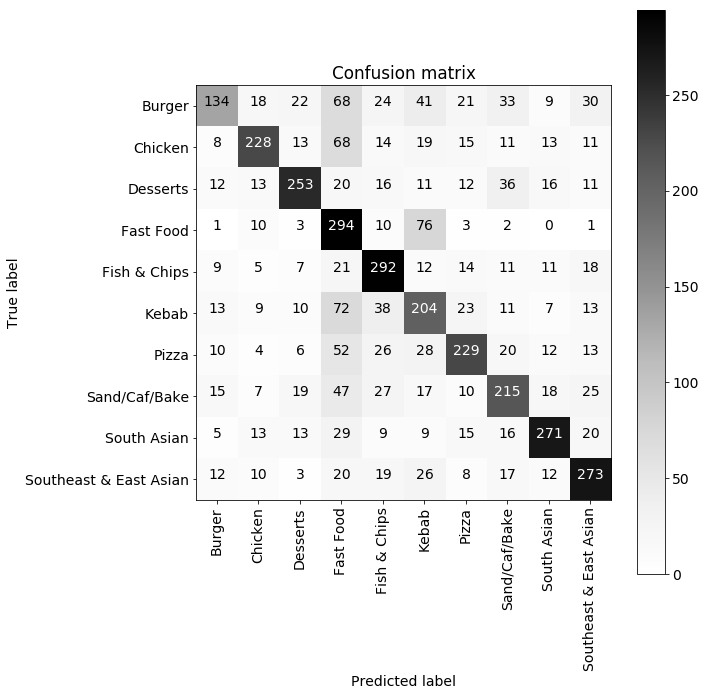

In [22]:
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(df_confusion, classes = results['label_final'], figsize=(10,10), cmap="Greys")


In [112]:
#Precision = tp / tp + fp
recall = np.diag(df_confusion) / np.sum(df_confusion, axis = 1)
precision = np.diag(df_confusion) / np.sum(df_confusion, axis = 0)

In [119]:
cats = bal_df.label_final.unique()
cats.sort()
data = [[cats],[recall],[precision]] 
  
data = {'Cuisine':cats, 'Recall (sensitivity)':recall, 'Precision (PPV)':precision} 
df = pd.DataFrame(data) 

In [120]:
df.loc['mean'] = df.mean()

In [121]:
df

,Cuisine,Recall (sensitivity),Precision (PPV)
0,Burger,0.33250,0.607306
1,Chicken,0.56750,0.711599
2,Desserts,0.63500,0.713483
3,Fast Food,0.73500,0.425470
4,Fish & Chips,0.73000,0.595918
5,Kebab,0.51250,0.461712
6,Pizza,0.56750,0.661808
7,Sand/Caf/Bake,0.53250,0.568000
8,South Asian,0.68000,0.753463
9,Southeast & East Asian,0.67500,0.671642


In [113]:
recall

array([0.3325, 0.5675, 0.635 , 0.735 , 0.73  , 0.5125, 0.5675, 0.5325, 0.68  , 0.675 ])

In [114]:
precision

array([0.607306, 0.711599, 0.713483, 0.42547 , 0.595918, 0.461712, 0.661808, 0.568   , 0.753463, 0.671642])

In [115]:
recall.mean()

0.59675

In [116]:
precision.mean()

0.6170400215229391